# Transition to Supervised Learning 

### Step 1 Load all the necessary libraries 

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score


np.set_printoptions(precision=3)

### Step 2 Load the Merged File (same in DBSCAN)

In [2]:
# Load dataset
####### MAKE SURE TO ADJUST TO THE CORRECT PATH FOR YOURSELF ############
df = pd.read_csv("/Users/brandonfox/Downloads/merged_clean_milestone.csv")

# Convert time columns (in HH:MM format) to total minutes
def time_to_minutes(t):
    try:
        h, m = map(int, t.split(":"))
        return h * 60 + m
    except:
        return np.nan

# Apply time conversion to relevant columns
for col in df.columns:
    if df[col].dtype == 'object' and df[col].str.contains(':', na=False).any():
        df[col] = df[col].apply(time_to_minutes)

# Drop columns that are mostly missing (over 50%)
df_clean = df.dropna(axis=1, thresh=len(df) * 0.5)

# Drop rows with remaining missing values
df_clean = df_clean.dropna()


### Step 3 is to create a income estimate from the census data for each person based on their race, education, gender

So we have all of that data for the NHANES Model and we were able to get the census data from https://www.census.gov/library/publications/2024/demo/p60-282.html where there is a table with the median income based on each identifier. It will have a number for each race, a number for each level of education, and a number for each gender. We will take each number for each person and average the numbers for an estimated income based on each person's demographics.

In [3]:
# Load NHANES demographic data
demo_path = "/Users/brandonfox/Downloads/sl_seqn_demo.csv"
demo_df = pd.read_csv(demo_path)

# Load national income data
income_path = "/Users/brandonfox/Downloads/Income_race_edu_gender.csv"
income_df = pd.read_csv(income_path)

demo_df.columns = demo_df.columns.str.strip()
demo_df = demo_df.rename(columns={
    "RIAGENDR_x": "Gender",
    "RIDAGEYR_x": "Age",
    "RIDRETH3_x": "Race",
    "DMDEDUC2_x": "Education"
})

race_map = {
    1: "White",                   # Mexican American
    2: "Hispanic (any race)",     # Other Hispanic
    3: "White, not Hispanic",     # Non-Hispanic White
    4: "Black",                   # Non-Hispanic Black
    6: "Asian",                   # Non-Hispanic Asian
    7: "Other"                    # Multiracial/Other
}
demo_df["Race_Group"] = demo_df["Race"].map(race_map)

edu_map = {
    1: "No high school diploma",
    2: "No high school diploma",
    3: "High school, no college",
    4: "Some college",
    5: "Bachelor's degree or higher"
}

demo_df["Edu_Group"] = demo_df["Education"].map(edu_map)
gender_map = {1: "Male", 2: "Female"}
demo_df["Gender_Label"] = demo_df["Gender"].map(gender_map)

demo_df_filtered = demo_df.dropna(subset=["Race_Group", "Edu_Group", "Gender_Label"])

income_reference = pd.DataFrame({
    "Race_Group": [
        "White", "White, not Hispanic", "Black", "Asian", "Hispanic (any race)",
        "White, not Hispanic", "Black", "Asian", "Hispanic (any race)", "White, not Hispanic"
    ],
    "Edu_Group": [
        "Bachelor's degree or higher", "Bachelor's degree or higher", "High school, no college",
        "Bachelor's degree or higher", "Some college", "Some college",
        "No high school diploma", "Some college", "Bachelor's degree or higher", "High school, no college"
    ],
    "Gender_Label": [
        "Male", "Male", "Female", "Male", "Female", "Female",
        "Male", "Female", "Female", "Male"
    ],
    "Median_Income": [
        119400, 126800, 55810, 112800, 73610, 73610,
        36230, 73610, 126800, 55810
    ]
})

merged = pd.merge(
    demo_df_filtered,
    income_reference,
    on=["Race_Group", "Edu_Group", "Gender_Label"],
    how="left"
)

mean_income = income_reference["Median_Income"].mean()
merged["Median_Income"] = merged["Median_Income"].fillna(mean_income)

income_estimates = merged[["SEQN", "Race_Group", "Edu_Group", "Gender_Label", "Median_Income"]]

print(income_estimates.head())

       SEQN           Race_Group                Edu_Group Gender_Label  \
0  130391.0  White, not Hispanic  High school, no college       Female   
1  130395.0                Other  High school, no college       Female   
2  130396.0  White, not Hispanic             Some college       Female   
3  130397.0  White, not Hispanic  High school, no college       Female   
4  130408.0                Black   No high school diploma         Male   

   Median_Income  
0        85448.0  
1        85448.0  
2        73610.0  
3        85448.0  
4        36230.0  


### Step 4 Feature Preparation for Modeling

In [4]:
# === Merge Income Estimate to Main Dataset ===
df_merged = df_clean.merge(income_estimates[["SEQN", "Median_Income"]], on="SEQN", how="left")

# Fill missing incomes with the overall mean
overall_mean_income = income_estimates["Median_Income"].mean()
df_merged["Median_Income"] = df_merged["Median_Income"].fillna(overall_mean_income)

# Top Features from DBSCAN + income
top_features = [
    'SLQ300', 'SLQ320', 'SLQ330', 'SLQ310', 'RIDAGEYR', 'DMDHHSIZ',
    'INDFMPIR', 'FNQ540', 'FNQ520', 'FNQ510', 'DMDEDUC2',
    'RIAGENDR', 'FNQ460', 'HUQ055', 'HUQ090', 'FNQ530', 'HUQ030', 'Median_Income'
]

# PHQ9 columns
target_col = 'PHQ9_SEVERITY'  

# Subset the dataset
modeling_df = df_merged[['SEQN', target_col] + top_features].dropna(subset=[target_col])



### Step 5: Rename for Readability

In [5]:
# Rename columns for interpretation
column_mapping = {
    'DMDHHSIZ': 'Total number of people in the Household',
    'DMDEDUC2': 'Education level - Adults 20+',
    'FNQ460': 'Difficulty remembering or concentrating',
    'FNQ510': 'How often feel worried/nervous/anxious',
    'FNQ520': 'Level of feeling worried/nervous/anxious',
    'FNQ530': 'How often feel depressed',
    'FNQ540': 'Level of feeling depressed',
    'HUQ030': 'Routine place to go for healthcare',
    'HUQ055': 'Past 12 months had video conf w/Dr?',
    'HUQ090': 'Seen mental health professional/past yr',
    'INDFMPIR': 'Ratio of family income to poverty',
    'RIAGENDR': 'Gender',
    'RIDAGEYR': 'Age in years at screening',
    'SLQ300': 'Usual sleep time on weekdays or workdays',
    'SLQ310': 'Usual wake time on weekdays or workdays',
    'SLQ320': 'Usual sleep time on weekends',
    'SLQ330': 'Usual wake time on weekends',
    'SEQN': 'Respondent sequence number'
}

modeling_df = modeling_df.rename(columns=column_mapping)


### Step 6: Modeling Setup (Logistic, RF, SVM)

In [8]:
# Define features excluding non-predictor columns
feature_cols = [col for col in modeling_df.columns if col not in ['Respondent sequence number', 'PHQ9_TOTAL', 'PHQ9_SEVERITY']]

X = modeling_df[feature_cols]  # predictors including Median_Income
y = modeling_df['PHQ9_SEVERITY']  # categorical depression severity labels

# Impute missing values if any (recommended before scaling)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Train-test split with stratification to keep class balance
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)


### Step 7: Run the Models

=== Logistic Regression Classification Report ===
                   precision    recall  f1-score   support

             Mild       0.26      0.12      0.17        96
         Moderate       0.27      0.10      0.14        41
Moderately Severe       0.00      0.00      0.00        17
     None-minimal       0.68      0.95      0.79       251
           Severe       0.00      0.00      0.00         8

         accuracy                           0.62       413
        macro avg       0.24      0.23      0.22       413
     weighted avg       0.50      0.62      0.54       413



/Users/brandonfox/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/brandonfox/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/brandonfox/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/brandonfox/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/brandonfox/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_

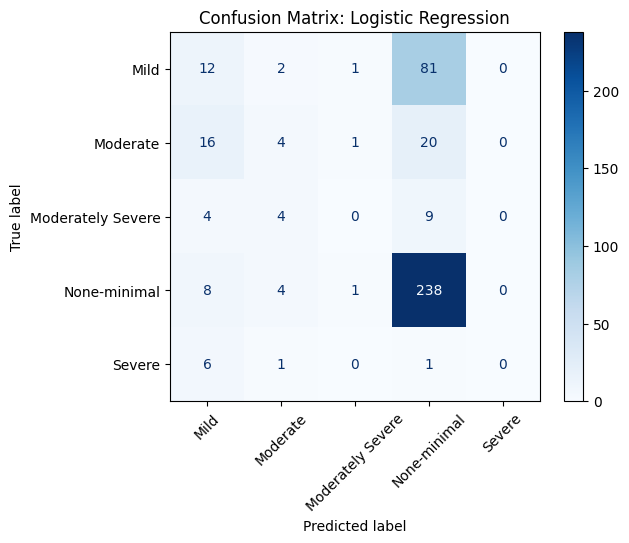

Logistic Regression ROC-AUC (OvR, macro): 0.792


=== Random Forest Classification Report ===
                   precision    recall  f1-score   support

             Mild       0.42      0.26      0.32        96
         Moderate       0.43      0.44      0.43        41
Moderately Severe       0.86      0.35      0.50        17
     None-minimal       0.80      0.97      0.88       251
           Severe       0.00      0.00      0.00         8

         accuracy                           0.71       413
        macro avg       0.50      0.40      0.43       413
     weighted avg       0.66      0.71      0.67       413



/Users/brandonfox/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brandonfox/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brandonfox/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

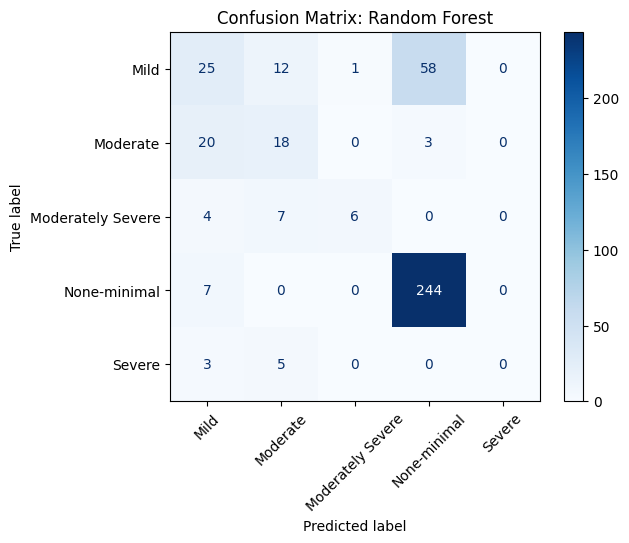

Random Forest ROC-AUC (OvR, macro): 0.884


=== Support Vector Machine Classification Report ===
                   precision    recall  f1-score   support

             Mild       0.35      0.19      0.24        96
         Moderate       0.11      0.02      0.04        41
Moderately Severe       0.00      0.00      0.00        17
     None-minimal       0.69      0.97      0.81       251
           Severe       0.00      0.00      0.00         8

         accuracy                           0.63       413
        macro avg       0.23      0.24      0.22       413
     weighted avg       0.51      0.63      0.55       413



/Users/brandonfox/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brandonfox/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brandonfox/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

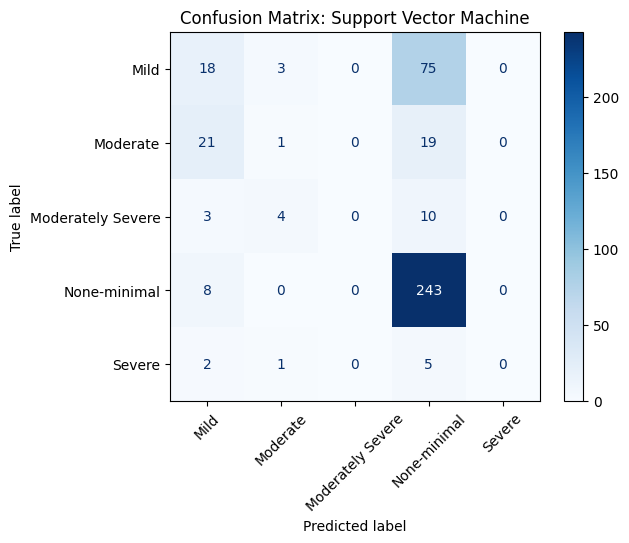

Support Vector Machine ROC-AUC (OvR, macro): 0.785




In [ ]:
# Prepare features and target
feature_cols = [col for col in modeling_df.columns if col not in ['Respondent sequence number', 'PHQ9_TOTAL', 'PHQ9_SEVERITY']]
X = modeling_df[feature_cols]
y = modeling_df['PHQ9_SEVERITY']

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Encode target labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split with stratify
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Helper function to train, predict, and report
def train_evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
    print(f"=== {model_name} Classification Report ===")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()
    
    if y_proba is not None:
        auc = roc_auc_score(y_test, y_proba, multi_class="ovr", average="macro")
        print(f"{model_name} ROC-AUC (OvR, macro): {auc:.3f}")
    print("\n")

# Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
train_evaluate_model(logreg, "Logistic Regression")

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
train_evaluate_model(rf, "Random Forest")

# Support Vector Machine (with probability=True for ROC-AUC)
svm = SVC(probability=True, random_state=42)
train_evaluate_model(svm, "Support Vector Machine")


# Classification Model Performance Summary

In this analysis, we evaluated three supervised learning models—**Logistic Regression**, **Random Forest**, and **Support Vector Machine (SVM)**—to classify depression severity levels based on the `PHQ9_SEVERITY` categories: *None-minimal, Mild, Moderate, Moderately Severe,* and *Severe*.

## Data and Target

The target variable was the binned PHQ-9 severity scores, and features included various demographic, behavioral, and health-related predictors. The dataset was split into training and testing sets with stratification to maintain class balance.

---

## Model Performance Metrics

| Model                | Accuracy | Macro F1-Score | ROC-AUC (OvR, Macro) |
|----------------------|----------|----------------|----------------------|
| Logistic Regression   | 0.62     | 0.22           | 0.792                |
| Random Forest        | 0.71     | 0.43           | 0.884                |
| Support Vector Machine | 0.63   | 0.22           | 0.785                |

---

## Detailed Model Insights

### Logistic Regression

- **Accuracy:** 62%
- **F1 Scores:** Moderate for *None-minimal* (0.79), but very low for severe categories (0.00 for *Moderately Severe* and *Severe*).
- **ROC-AUC:** 0.792, indicating decent overall separability.
- **Observations:** Model performs well on the majority class (*None-minimal*) but struggles to correctly classify less frequent, severe categories, resulting in poor recall and precision for those labels.
- **Warnings:** Model training generated warnings about numeric instability and deprecated parameters, suggesting careful tuning or alternative approaches (e.g., OneVsRestClassifier) may be necessary.

### Random Forest

- **Accuracy:** 71%
- **F1 Scores:** Strong performance on *None-minimal* (0.88) and better recall on *Moderately Severe* (0.35) compared to logistic regression.
- **ROC-AUC:** Highest among the models at 0.884, indicating better overall discrimination ability.
- **Observations:** Random Forest shows the best overall performance, with improved classification of minority classes, though *Severe* remains difficult to predict (0.00 F1).
- **Warnings:** Some precision metrics were ill-defined due to zero predicted samples for certain classes, highlighting ongoing challenges with severe categories.

### Support Vector Machine (SVM)

- **Accuracy:** 63%
- **F1 Scores:** Comparable to logistic regression but lower overall, especially poor recall on *Moderate* (0.02) and no detection of *Severe* cases.
- **ROC-AUC:** 0.785, slightly below logistic regression.
- **Observations:** The SVM struggles with class imbalance and minority classes, with performance skewed toward the majority class.

---

## Overall Interpretation

- **Class Imbalance Challenge:** All models exhibit strong performance on the *None-minimal* depression category due to its majority representation in the dataset but perform poorly on severe categories, which have much fewer samples.
- **Random Forest Advantage:** The Random Forest classifier outperforms logistic regression and SVM across accuracy, macro F1, and ROC-AUC metrics, showing better balance in predicting minority classes.
- **Potential Improvements:** Future work should focus on addressing class imbalance via techniques such as oversampling, class weighting, or anomaly detection. Alternative model architectures or ensembling could also improve minority class recognition.

---



## Extract logistic regression coefficients and compute approximate confidence intervals
scikit-learn doesn't provide confidence intervals directly, but you can approximate them using the standard errors from the covariance matrix or use bootstrapping.

Since scikit-learn doesn’t provide the covariance matrix, I’ll give you a bootstrap example to estimate coefficient CIs.

In [26]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Assume you already have X_train, y_train, feature_cols, and logreg model initialized

n_bootstraps = 1000
coefs = []

for i in range(n_bootstraps):
    # Sample with replacement from train data indices
    idxs = np.random.choice(range(X_train.shape[0]), size=X_train.shape[0], replace=True)
    X_boot = X_train[idxs]
    y_boot = y_train[idxs]
    
    model = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
    model.fit(X_boot, y_boot)
    coefs.append(model.coef_[0])  # For OvR, take first class coefficients; adjust as needed

coefs = np.array(coefs)  # shape (n_bootstraps, n_features)

# Calculate mean and 95% CI
coef_mean = np.mean(coefs, axis=0)
coef_lower = np.percentile(coefs, 2.5, axis=0)
coef_upper = np.percentile(coefs, 97.5, axis=0)

coef_df = pd.DataFrame({
    'coef': coef_mean,
    '2.5%': coef_lower,
    '97.5%': coef_upper,
}, index=feature_cols)

print(coef_df)



/Users/brandonfox/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/brandonfox/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/brandonfox/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/brandonfox/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/brandonfox/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_

                                              coef      2.5%     97.5%
Usual sleep time on weekdays or workdays -0.019899 -0.234836  0.194723
Usual sleep time on weekends             -0.076450 -0.282937  0.151255
Usual wake time on weekends              -0.025953 -0.263533  0.224114
Usual wake time on weekdays or workdays   0.086796 -0.117683  0.296460
Age in years at screening                -0.053206 -0.230130  0.119606
Total number of people in the Household  -0.081069 -0.243241  0.087369
Ratio of family income to poverty        -0.087926 -0.278461  0.097671
Level of feeling depressed                0.127096 -0.052496  0.299844
Level of feeling worried/nervous/anxious  0.108357 -0.064478  0.292090
How often feel worried/nervous/anxious   -0.232614 -0.435962 -0.031537
Education level - Adults 20+              0.192151 -0.005826  0.406782
Gender                                   -0.006350 -0.167271  0.167878
Difficulty remembering or concentrating   0.077820 -0.094493  0.248371
Past 1

/Users/brandonfox/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/brandonfox/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/brandonfox/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/brandonfox/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/brandonfox/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_

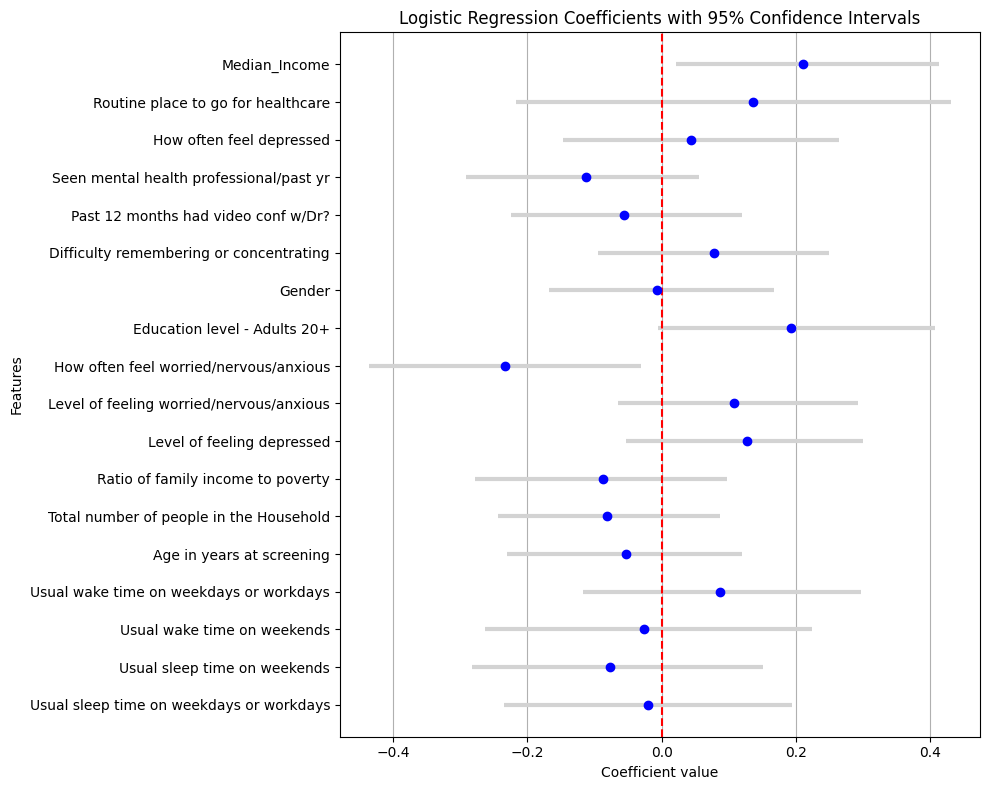

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.errorbar(coef_df['coef'], coef_df.index, 
             xerr=[coef_df['coef'] - coef_df['2.5%'], coef_df['97.5%'] - coef_df['coef']], 
             fmt='o', color='blue', ecolor='lightgray', elinewidth=3, capsize=0)
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Logistic Regression Coefficients with 95% Confidence Intervals")
plt.xlabel("Coefficient value")
plt.ylabel("Features")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


## Variable Importance from Random Forest
Random Forests provide a simple feature importance metric:

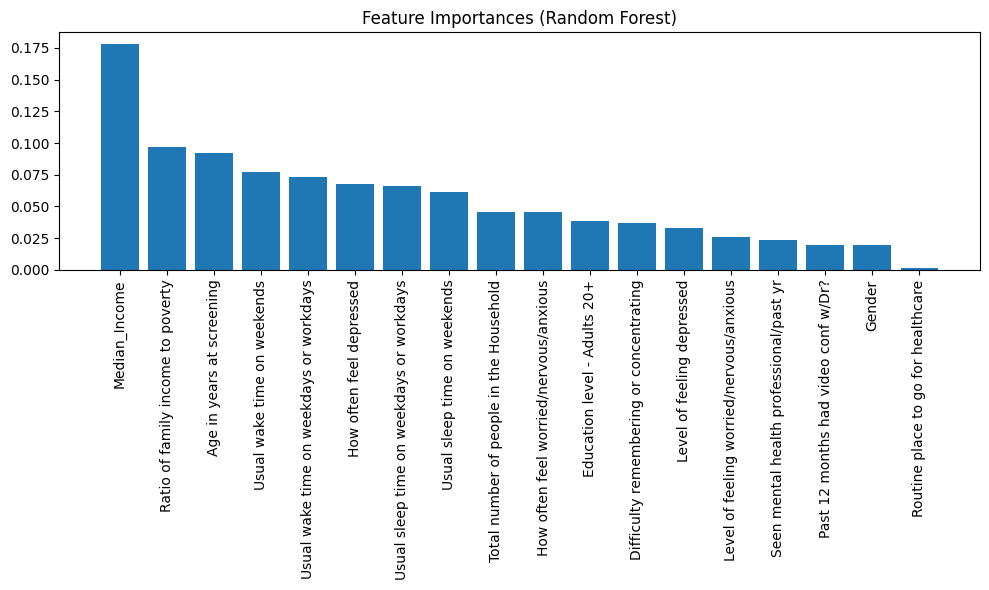

In [16]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_
indices = importances.argsort()[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_cols[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


## Permutation Feature Importance (Model-Agnostic)
Permutation importance measures the increase in prediction error when a feature’s values are randomly shuffled. It works for any fitted model.

/var/folders/cf/mxh1zsq915n4dygnhs9h6c1h0000gn/T/ipykernel_26047/3284425958.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(result.importances[sorted_idx].T,


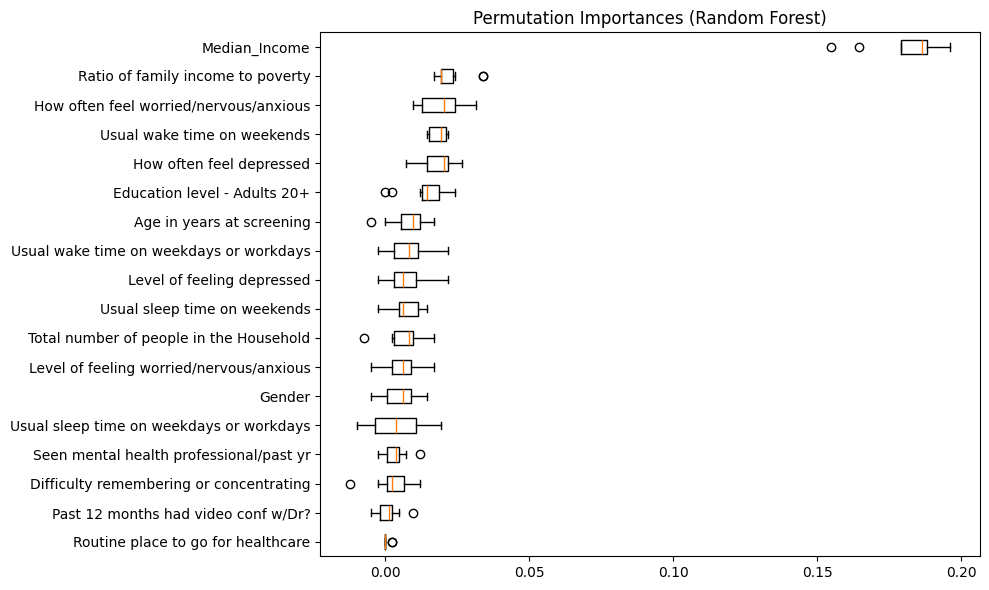

In [23]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10,6))
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=[feature_cols[i] for i in sorted_idx])
plt.title("Permutation Importances (Random Forest)")
plt.tight_layout()
plt.show()


## ROC Curves for Support Vector Machine (Multi-class OvR)

/var/folders/cf/mxh1zsq915n4dygnhs9h6c1h0000gn/T/ipykernel_26047/2139032137.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10').colors


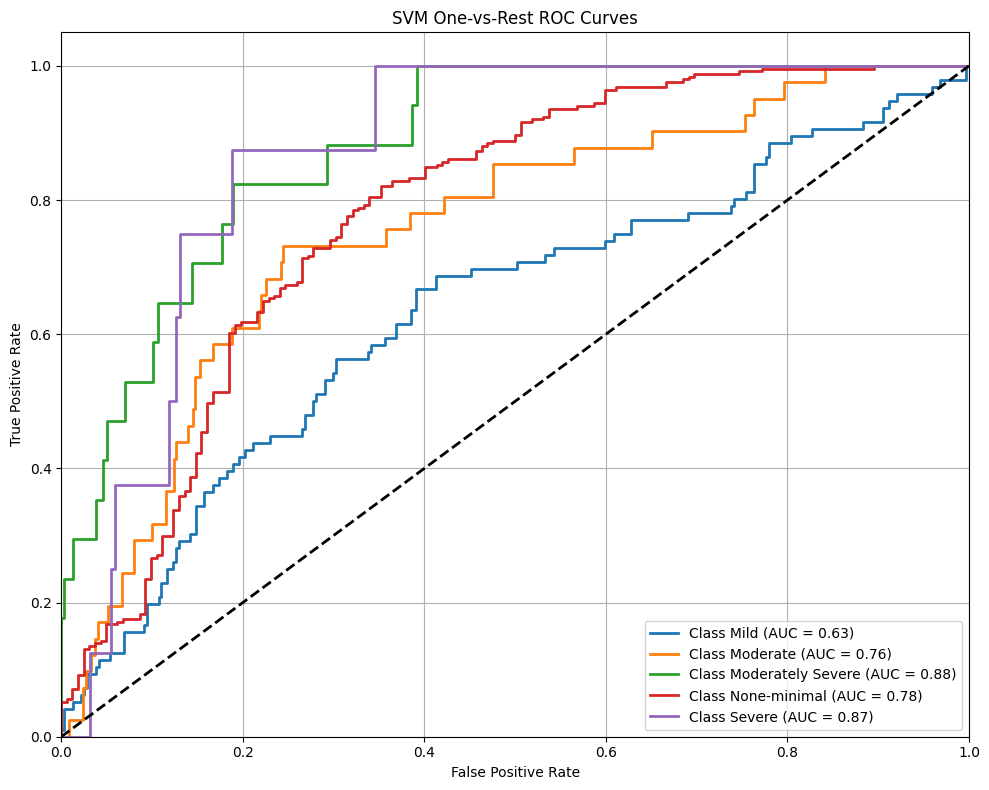

In [25]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the output labels for multi-class ROC curve plotting
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
n_classes = y_test_bin.shape[1]

# Predict probabilities for each class using the SVM
y_score = svm.predict_proba(X_test)

plt.figure(figsize=(10, 8))

colors = plt.cm.get_cmap('tab10').colors

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'Class {le.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM One-vs-Rest ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
